In [1]:
import tensorflow as tf
from datetime import datetime
import os

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [2]:
# Avoid Out Of Memory (OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tokenizer = Tokenizer()
data = open('../LSTM/irish-lyrics-eof.txt').read()

# corpus data normalized -> lower, split into strings by new line characters
c_data = data.lower().split("\n")

# fit the corpus data to the tokenizer
tokenizer.fit_on_texts(c_data)

# observe that we no longer use OOV instead we use +1
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)


{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [4]:
input_sequences = []

for line in c_data:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_len,
                                         padding='pre'))

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
x_train, x_val, y_train, y_val = train_test_split(xs, ys, test_size=0.2, random_state=42)

In [6]:
model = Sequential()
model.add(Embedding(total_words, 200, input_length=max_sequence_len-1))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dense(total_words, activation='softmax'))

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 200)           538000    
                                                                 
 lstm (LSTM)                 (None, 15, 256)           467968    
                                                                 
 dropout (Dropout)           (None, 15, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 512)           1574912   
                                                                 
 dropout_1 (Dropout)         (None, 15, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 2690)              6

In [7]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
epochs = 1000

history = model.fit(xs, ys, epochs=epochs, validation_data=(
    x_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/1000
377/377 [==============================] - 13s 22ms/step - loss: 6.8059 - accuracy: 0.0640 - val_loss: 6.3384 - val_accuracy: 0.0673
Epoch 2/1000
377/377 [==============================] - 7s 18ms/step - loss: 6.4912 - accuracy: 0.0657 - val_loss: 6.3326 - val_accuracy: 0.0673
Epoch 3/1000
377/377 [==============================] - 7s 19ms/step - loss: 6.4019 - accuracy: 0.0657 - val_loss: 6.1833 - val_accuracy: 0.0673
Epoch 4/1000
377/377 [==============================] - 7s 19ms/step - loss: 6.2681 - accuracy: 0.0695 - val_loss: 6.0347 - val_accuracy: 0.0781
Epoch 5/1000
377/377 [==============================] - 7s 19ms/step - loss: 6.1083 - accuracy: 0.0768 - val_loss: 5.8694 - val_accuracy: 0.0909
Epoch 6/1000
377/377 [==============================] - 7s 18ms/step - loss: 5.9413 - accuracy: 0.0799 - val_loss: 5.7221 - val_accuracy: 0.0855
Epoch 7/1000
377/377 [==============================] - 7s 19ms/step - loss: 5.8043 - accuracy: 0.0815 - val_loss: 5.5966 - val_a

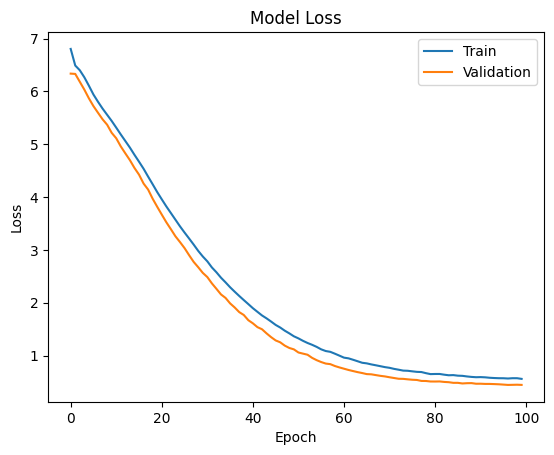

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

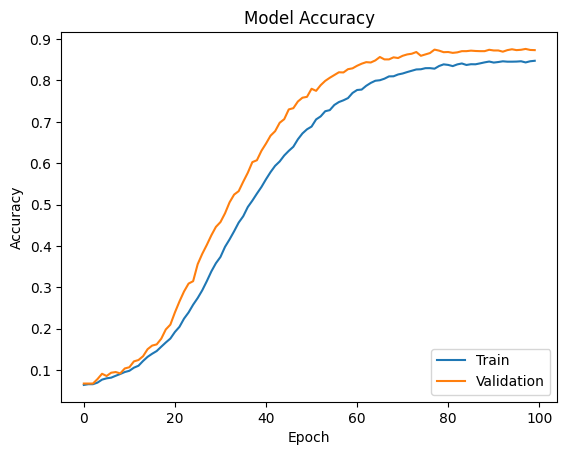

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [10]:
seed_text = "I've got a good feeling about this"
next_words = 20

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list],maxlen=max_sequence_len-1,padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 24ms/step
I've got a good feeling about this mountain day where the rose of tralee mad at love love love the be drown when the poor then found


In [11]:
# Define a unique model name based on the current timestamp
model_name = f'model_{str(datetime.now().strftime("%Y%m%d_%H%M%S"))}.h5'
model_path = os.path.join('LSTMModelsT', model_name)
# Save the trained model
model.save(model_path)
print(f"Trained model saved at: {model_path}")

Trained model saved at: LSTMModelsT\model_20230608_185915.h5


In [15]:
# Save the tokenizer with a unique filename
import pickle
tokenizer_file = f'tokenizer_{str(datetime.now().strftime("%Y%m%d_%H%M%S"))}.pkl'
os.makedirs('LSTM TokenizerT')
tokenizer_path = os.path.join('LSTM TokenizerT', tokenizer_file)

# Save the tokenizer
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved at: {model_path}")

Tokenizer saved at: LSTMModelsT\model_20230608_185915.h5
